Hello Fellow Kagglers,

This notebook demonstrates the data processing and training process in Tensorflow.

I am excited about this competition, because my Master Thesis was on sign language recognition.

**Data Processing**

Only lips, hands and arm pose coordinates are used.

A custom Tensorflow layer handles the data processing. In short, it filters all frames without coordinates for the hands and downsamples the input to 32 frames if it is too long.

**Model**

A transformer based model is used. The embedding layer makes an ambedding per landmark(lips/left hand/right hand/arm pose) and merges these embedding with fully connected layers. The transformer consists of just 2 blocks with a simple mean pooling and fully connected layers for classification.


**V2**

* Learnable attention weights for each landmark
* Removed layer normalisation in embedding to prevent double layer normalisation at the end of embedding and start of transformer
* Removed additional fully connected layer in head before classification layer

**V3**

* Using all data for training
* Increased final embedding size 384 -> 512
* Added 10% dropout in classification layer
* Increased number of epoch 50 -> 100
* Number of transformer heads 8 -> 4

If you have any feedback or questions, please feel free to leave a comment.

Expect updates in the coming weeks!

In [1]:
# !pip install -q tensorflow_addons
# !pip install -q wandb
# !pip install -q pyarrow
# !pip install -q fastparquet

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import datetime

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import layers
from utils.Utils import print_shape_dtype, pd_read_s3_parquet, upload_file, get_dataset_partitions_tf 
from layers.PreprocessLayerV2 import PreprocessLayerV2


import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
import boto3
import io
import wandb
import json

2023-04-18 01:44:27.505053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 01:44:28.133322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
tf.get_logger().setLevel('INFO')

# Config

In [3]:
with open("./config/config.json") as fp:
    config = json.load(fp)

In [5]:
# Setup Weights and Biases
wandb.login()

wandb: Currently logged in as: deanna-emery (w251-asl-fp). Use `wandb login --relogin` to force relogin


True

In [6]:
LOG_DIR = './logs/fit'
wandb.tensorboard.patch(root_logdir= LOG_DIR)
wandb.init(project='w251-GISLR-Final', 
           config=config,
          sync_tensorboard=True)

In [4]:
USE_VAL = True

DIM_NAMES = ['x', 'y']
SEED = 42

# Samples

In [5]:
s3_client = boto3.client(
    "s3"
)

In [6]:
AWS_S3_BUCKET = "w251-asl-data"
AWS_S3_BUCKET_2 = "asl-project-bucket2"

TRAIN_CSV_FILE = "raw-data/train.csv"

In [7]:
# data_version = config["DATA_VERSION"]

data_version = 6


X = s3_client.get_object(Bucket=AWS_S3_BUCKET_2, Key=f'processed-data/v{data_version}/X.npy')
X = np.load(io.BytesIO(X['Body'].read()))

y = s3_client.get_object(Bucket=AWS_S3_BUCKET_2, Key=f'processed-data/v{data_version}/y.npy')
y = np.load(io.BytesIO(y['Body'].read()))

NON_EMPTY_FRAME_IDXS = s3_client.get_object(Bucket=AWS_S3_BUCKET_2, Key=f'processed-data/v{data_version}/NON_EMPTY_FRAME_IDXS.npy')
NON_EMPTY_FRAME_IDXS = np.load(io.BytesIO(NON_EMPTY_FRAME_IDXS['Body'].read()))
    
print_shape_dtype([X, y, NON_EMPTY_FRAME_IDXS], ['X', 'y', 'NON_EMPTY_FRAME_IDXS'])
print(f'# NaN Values X: {np.isnan(X).sum()}')

X shape: (94477, 38, 454), dtype: float32
y shape: (94477,), dtype: int32
NON_EMPTY_FRAME_IDXS shape: (94477, 38), dtype: float32
# NaN Values X: 0


In [8]:
# # Read in from local filesystem instead since reading from S3 takes too long. 

# X = np.load("./X.npy")
# y = np.load("./y.npy")
# NON_EMPTY_FRAME_IDXS = np.load("./NON_EMPTY_FRAME_IDXS.npy")

# print_shape_dtype([X, y, NON_EMPTY_FRAME_IDXS], ['X', 'y', 'NON_EMPTY_FRAME_IDXS'])
# print(f'# NaN Values X: {np.isnan(X).sum()}')

In [9]:
# def get_sample(X, y, NON_EMPTY_FRAME_IDXS, batch_size=config["BATCH_SIZE"]): #TODO: Change this in config.
    
#     # Arrays to store batch in
#     X_batch = np.zeros([batch_size, config["INPUT_SIZE"], config["N_COLS"], config["N_DIMS"]], dtype=np.float32)
#     y_batch = np.arange(0, batch_size, dtype=np.int32)
#     non_empty_frame_idxs_batch = np.zeros([batch_size, config["INPUT_SIZE"]], dtype=np.float32)
    
#     # Dictionary mapping ordinally encoded sign to corresponding sample indices
#     CLASS2IDXS = {}
#     for i in range(config["NUM_CLASSES"]):
#         CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
#     while True:
#         # Fill batch arrays
#         for i in range(config["NUM_CLASSES"]):
#             idxs = np.random.choice(CLASS2IDXS[i], n)
#             X_batch[i*n:(i+1)*n] = X[idxs]
#             non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
#         yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [10]:
# # LIPS
# LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
# LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
# LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
# LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

# fig, axes = plt.subplots(3, 1, figsize=(15, config["N_DIMS"]*6))
   
# for col, ll in enumerate(tqdm( np.transpose(X[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, config["N_DIMS"], -1]) )):
#     for dim, l in enumerate(ll):
#         v = l[np.nonzero(l)]
#         if dim == 0: # X
#             LIPS_MEAN_X[col] = v.mean()
#             LIPS_STD_X[col] = v.std()
#         if dim == 1: # Y
#             LIPS_MEAN_Y[col] = v.mean()
#             LIPS_STD_Y[col] = v.std()
        
#         axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
# for ax, dim_name in zip(axes, DIM_NAMES):
#     ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
#     ax.tick_params(axis='x', labelsize=8)
#     ax.grid(axis='y')

# plt.subplots_adjust(hspace=0.50)
# plt.show()

# LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
# LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

In [11]:
# # LEFT HAND
# LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# # RIGHT HAND
# RIGHT_HANDS_MEAN_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
# RIGHT_HANDS_MEAN_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
# RIGHT_HANDS_STD_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
# RIGHT_HANDS_STD_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)

# fig, axes = plt.subplots(3, 1, figsize=(15, config["N_DIMS"]*6))
   
# for col, ll in enumerate(tqdm( np.transpose(X[:,:,HAND_IDXS], [2,3,0,1]).reshape([HAND_IDXS.size, config["N_DIMS"], -1]) )):
#     for dim, l in enumerate(ll):
#         v = l[np.nonzero(l)]
#         if dim == 0: # X
#             if col < RIGHT_HAND_IDXS.size: # LEFT HAND
#                 LEFT_HANDS_MEAN_X[col] = v.mean()
#                 LEFT_HANDS_STD_X[col] = v.std()
#             else:
#                 RIGHT_HANDS_MEAN_X[col - LEFT_HAND_IDXS.size] = v.mean()
#                 RIGHT_HANDS_STD_X[col - LEFT_HAND_IDXS.size] = v.std()
#         if dim == 1: # Y
#             if col < RIGHT_HAND_IDXS.size: # LEFT HAND
#                 LEFT_HANDS_MEAN_Y[col] = v.mean()
#                 LEFT_HANDS_STD_Y[col] = v.std()
#             else: # RIGHT HAND
#                 RIGHT_HANDS_MEAN_Y[col - LEFT_HAND_IDXS.size] = v.mean()
#                 RIGHT_HANDS_STD_Y[col - LEFT_HAND_IDXS.size] = v.std()
        
#         axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
# for ax, dim_name in zip(axes, DIM_NAMES):
#     ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
#     ax.tick_params(axis='x', labelsize=8)
#     ax.grid(axis='y')

# plt.subplots_adjust(hspace=0.50)
# plt.show()

# LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
# LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
# RIGHT_HANDS_MEAN = np.array([RIGHT_HANDS_MEAN_X, RIGHT_HANDS_MEAN_Y]).T
# RIGHT_HANDS_STD = np.array([RIGHT_HANDS_STD_X, RIGHT_HANDS_STD_Y]).T

In [12]:
# # POSE
# POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
# POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
# POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
# POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

# fig, axes = plt.subplots(3, 1, figsize=(15, config["N_DIMS"]*6))
   
# for col, ll in enumerate(tqdm( np.transpose(X[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, config["N_DIMS"], -1]) )):
#     for dim, l in enumerate(ll):
#         v = l[np.nonzero(l)]
#         if dim == 0: # X
#             POSE_MEAN_X[col] = v.mean()
#             POSE_STD_X[col] = v.std()
#         if dim == 1: # Y
#             POSE_MEAN_Y[col] = v.mean()
#             POSE_STD_Y[col] = v.std()
        
#         axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
# for ax, dim_name in zip(axes, DIM_NAMES):
#     ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
#     ax.tick_params(axis='x', labelsize=8)
#     ax.grid(axis='y')

# plt.subplots_adjust(hspace=0.50)
# plt.show()

# POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
# POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

# Model Config

In [8]:
TRANSFORMERV1 = True

# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
FACE_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2
NUM_HEADS = 4

# Dropout
EMBEDDING_DROPOUT = 0.0
MLP_DROPOUT_RATIO = 0.05
CLASSIFIER_DROPOUT_RATIO = 0.1

# Initiailizers
# INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
# INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
ACTIVATION = tf.keras.activations.gelu

VERBOSE = True

In [9]:
FACE_IDXS = [0, 6, 7, 11, 12, 13, 14, 15, 17, 22, 23, 24, 25, 26, 30, 31, 
                     33, 37, 38, 39, 40, 41, 42, 56, 61, 62, 72, 73, 74, 76, 77, 
                     78, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 95, 96, 110, 112, 
                     113, 122, 128, 130, 133, 144, 145, 146, 153, 154, 155, 157, 158, 
                     159, 160, 161, 163, 168, 173, 178, 179, 180, 181, 183, 184, 185, 
                     188, 189, 190, 191, 193, 196, 197, 232, 233, 243, 244, 245, 246, 
                     247, 249, 252, 253, 254, 255, 256, 259, 260, 263, 267, 268, 269, 
                     270, 271, 272, 286, 291, 292, 302, 303, 304, 306, 307, 308, 310, 
                     311, 312, 314, 316, 317, 318, 319, 320, 321, 324, 325, 339, 341, 
                     351, 357, 359, 362, 373, 374, 375, 380, 381, 382, 384, 385, 386, 
                     387, 388, 390, 398, 402, 403, 404, 405, 407, 408, 409, 412, 413, 
                     414, 415, 417, 419, 453, 463, 464, 465, 466, 467]
POSE_IDXS = np.arange(489, 514)
LEFT_HAND_IDXS = np.arange(468, 489)
RIGHT_HAND_IDXS = np.arange(522, 543)

# All landmarks that are used for modeling. 
LANDMARK_IDXS = np.concatenate((FACE_IDXS, POSE_IDXS, LEFT_HAND_IDXS, RIGHT_HAND_IDXS))

# Indicies after landmarks have been filtered. 
FACE_START = 0
LEFT_HAND_START = len(FACE_IDXS)
POSE_START = LEFT_HAND_START + len(LEFT_HAND_IDXS)
RIGHT_HAND_START = POSE_START + len(POSE_IDXS)

# Length of landmarks.
FACE_LEN = len(FACE_IDXS)
POSE_LEN = POSE_IDXS.size
LEFT_HAND_LEN = LEFT_HAND_IDXS.size
RIGHT_HAND_LEN = RIGHT_HAND_IDXS.size

In [10]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([config["INPUT_SIZE"], config["N_COLS"] * config["N_DIMS"]], dtype=tf.float32, name='FRAMES')
    non_empty_frame_idxs = tf.keras.layers.Input([config["INPUT_SIZE"]], dtype=tf.float32, name='NON_EMPTY_FRAME_IDXS')
    
    # Attention Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)
    
    # Slice out face indicies       
    face = tf.slice(frames, [0, 0, FACE_START], [-1, config["INPUT_SIZE"], FACE_LEN * 2])
    # face = tf.reshape(frames, [-1, config["INPUT_SIZE"], FACE_LEN*2])
    
     # Slice out left_hand indicies
    left_hand = tf.slice(frames, [0, 0, LEFT_HAND_START * 2], [-1, config["INPUT_SIZE"], LEFT_HAND_LEN * 2])
    # left_hand = tf.reshape(frames, [-1, config["INPUT_SIZE"], len(LEFT_HAND_IDXS)*2])

    # Slice out pose indicies
    pose = tf.slice(frames, [0, 0, POSE_START * 2], [-1, config["INPUT_SIZE"], POSE_LEN * 2])
    # pose = tf.reshape(frames, [-1, config["INPUT_SIZE"], len(POSE_IDXS)*2])

    # Slice out right_hand indicies
    right_hand = tf.slice(frames, [0, 0, RIGHT_HAND_START * 2], [-1, config["INPUT_SIZE"], RIGHT_HAND_LEN * 2])
    # right_hand = tf.reshape(frames, [-1, config["INPUT_SIZE"], len(RIGHT_HAND_IDXS)*2])
    
    embedding_layer = layers.Embedding(config["INPUT_SIZE"], FACE_UNITS, HANDS_UNITS, POSE_UNITS, UNITS, ACTIVATION)
    x = embedding_layer(face, left_hand, right_hand, pose, non_empty_frame_idxs)
    transformer_input_shape = x.shape
    
    if (TRANSFORMERV1):
        # Encoder Transformer Blocks
        transformer_layer = layers.Transformer(NUM_BLOCKS, LAYER_NORM_EPS, UNITS, MLP_RATIO, MLP_DROPOUT_RATIO, ACTIVATION)
        x = transformer_layer(x, mask)
    else:
        encoder_input_shape = transformer_input_shape
        for _ in range(NUM_BLOCKS):
            x = layers.TransformerV2(encoder_input_shape, NUM_HEADS, UNITS, MLP_DROPOUT_RATIO, LAYER_NORM_EPS)(x)
            encoder_input_shape = x.shape[1:]  # Update the input shape for the next encoder
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(config["NUM_CLASSES"], activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=config["LEARNING_RATE"], weight_decay=config["WEIGHT_DECAY"])
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, run_eagerly=True)
    
    return model

In [11]:
# Load dataset
with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(({"FRAMES": X, "NON_EMPTY_FRAME_IDXS": NON_EMPTY_FRAME_IDXS}, y))
    
# with tf.device('CPU'):
#     dataset = tf.data.Dataset.from_tensor_slices(({"FRAMES": X[:100], "NON_EMPTY_FRAME_IDXS": NON_EMPTY_FRAME_IDXS[:100]}, y[:100]))

train, validation, test = get_dataset_partitions_tf(dataset, X.shape[0], train_split=0.8, val_split=0.1, 
                                                test_split=0.1, shuffle=True, shuffle_size=10000, seed=42)


2023-04-18 01:47:57.758564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 01:47:57.779789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 01:47:57.781779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
# inputs = X[:2]
# attn_output = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=inputs.shape[-1])(inputs, inputs)
# attn_output = tf.keras.layers.Dropout(.10)(attn_output)
# out1 = tf.keras.layers.LayerNormalization(epsilon=.000001)(inputs + attn_output)
# ff_output = tf.keras.layers.Dense(512, activation='relu')(out1)
# ff_output = tf.keras.layers.Dropout(.10)(ff_output)
# ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)  # Add this line to match the dimensions
# out2 = tf.keras.layers.LayerNormalization(epsilon=.000001)(out1 + ff_output)
# out2

In [21]:
# model = get_model()
# model.evaluate(dataset.batch(2))

In [22]:
# # Plot model summary
# model.summary(expand_nested=True)

In [23]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# Weight Initialization

In [24]:
# N = 32
# y_pred = model.predict(dummy_dataset, verbose=VERBOSE, steps=N).flatten()

# plt.figure(figsize=(12,5))
# plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
# pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
# plt.xlim(0, max(y_pred) * 1.1)
# plt.grid()
# plt.legend()
# plt.show()

# Learning Rate Scheduler

In [10]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=config["N_EPOCHS"], warm_method='log'):
    
    if current_step < num_warmup_steps:
        if warm_method == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [11]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=config["N_WARMUP_EPOCHS"], lr_max=config["LEARNING_RATE"], num_cycles=0.50) for step in range(config["N_EPOCHS"])]
# Plot Learning Rate Schedule
# plot_lr_schedule(LR_SCHEDULE, epochs=config["N_EPOCHS"])
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [12]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=config['WD_RATIO']):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Weight Decay Callback

# Performance Benchmark

In [28]:
# %%timeit -n 100
# # Verify model prediction is <<<100ms
# model.predict_on_batch({ 'FRAMES': X[:1], 'NON_EMPTY_FRAME_IDXS': NON_EMPTY_FRAME_IDXS[:1] })
# pass

# Training

# Train

In [29]:
# Clear all models in GPU
tf.keras.backend.clear_session()

# Get new fresh model
model = get_model()

# Sanity Check
model.summary()

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Actual Training
history = model.fit(
        train.batch(config['TRAIN_BATCH_SIZE']),
        epochs=config["N_EPOCHS"],
        validation_data=validation.batch(config["BATCH_SIZE_VAL"]),
        callbacks=[
            lr_callback,
            WeightDecayCallback(config["WD_RATIO"]),
            tensorboard_callback
          ],
        verbose = VERBOSE,
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 NON_EMPTY_FRAME_IDXS (InputLay  [(None, 38)]        0           []                               
 er)                                                                                              
                                                                                                  
 FRAMES (InputLayer)            [(None, 38, 454)]    0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 38)          0           ['NON_EMPTY_FRAME_IDXS[0][0]']   
                                                                                                  
 tf.slice (TFOpLambda)          (None, 38, 320)      0           ['FRAMES[0][0]']             

2023-04-16 22:11:22.472479: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6519668816 exceeds 10% of free system memory.
2023-04-16 22:11:23.416890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-16 22:11:25.991129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [94477,38]
	 [[{{node Placeholder/_1}}]]



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
learning rate: 1.00e-04, weight decay: 5.00e-06
Epoch 1/150


2023-04-16 22:11:27.083142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


148/148 [==============================] - ETA: 0s - loss: 5.1806 - acc: 0.0394 - top_5_acc: 0.1252 - top_10_acc: 0.1931

2023-04-16 22:11:55.685621: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6519668816 exceeds 10% of free system memory.
2023-04-16 22:11:59.153339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [94477]
	 [[{{node Placeholder/_2}}]]


148/148 [==============================] - 36s 237ms/step - loss: 5.1806 - acc: 0.0394 - top_5_acc: 0.1252 - top_10_acc: 0.1931 - val_loss: 3.8708 - val_acc: 0.1648 - val_top_5_acc: 0.4054 - val_top_10_acc: 0.5355 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.998903417374228e-05.
learning rate: 1.00e-04, weight decay: 5.00e-06
Epoch 2/150
148/148 [==============================] - 31s 212ms/step - loss: 3.2153 - acc: 0.2759 - top_5_acc: 0.5555 - top_10_acc: 0.6738 - val_loss: 2.4596 - val_acc: 0.4366 - val_top_5_acc: 0.7117 - val_top_10_acc: 0.7995 - lr: 9.9989e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.995614150494293e-05.
learning rate: 1.00e-04, weight decay: 5.00e-06
Epoch 3/150
148/148 [==============================] - 32s 213ms/step - loss: 2.3532 - acc: 0.4451 - top_5_acc: 0.7256 - top_10_acc: 0.8104 - val_loss: 1.9618 - val_acc: 0.5433 - val_top_5_acc: 0.7890 - val_top_10_acc: 0.8543 - lr: 9.9956e-05

Epoch 4: LearningRateSched

In [32]:
# Save Model Weights
version = 2
model.save_weights(f'tf_models/v{version}_model.h5')

s3_client.upload_file(Filename=f'tf_models/v{version}_model.h5',
                  Bucket=AWS_S3_BUCKET_2,
                  Key=f'tf_models/v{version}_model.h5')

In [13]:
model = get_model()
model.load_weights('tf_models/v2_model.h5')

In [14]:
model.evaluate(test.batch(256))

2023-04-18 01:49:09.084358: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6519668816 exceeds 10% of free system memory.
2023-04-18 01:49:12.677603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [94477,38]
	 [[{{node Placeholder/_1}}]]


 2/37 [>.............................] - ETA: 2s - loss: 1.1730 - acc: 0.8301 - top_5_acc: 0.9238 - top_10_acc: 0.9492  

2023-04-18 01:49:14.481635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


37/37 [==============================] - 8s 66ms/step - loss: 1.1007 - acc: 0.8486 - top_5_acc: 0.9341 - top_10_acc: 0.9528


[1.1007401943206787,
 0.8485553860664368,
 0.9340670704841614,
 0.9527992606163025]

In [15]:
# Dictionaries to translate sign <-> ordinal encoded sign
train_file = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=TRAIN_CSV_FILE)
train = pd.read_csv(train_file.get("Body"))

# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [21]:
# if USE_VAL:
    # Validation Predictions
    # y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
y_val_pred = model.predict(test.batch(256), verbose=2).argmax(axis=1)
    # Label
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(config["NUM_CLASSES"])]

2023-04-18 03:23:45.563914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [94477,38,454]
	 [[{{node Placeholder/_0}}]]


37/37 - 7s - 7s/epoch - 185ms/step


# Landmark Attention Weights

In [14]:
# Landmark Weights
weights = scipy.special.softmax(model.get_layer('embedding').weights[15])

print(weights)

landmarks = ['face_embedding', 'left_hand_embedding', 'pose_embedding', 'right_hand_embedding']

# Learned attention weights, initialized at uniform 25%
for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

[[3.4831787e-06 4.2217339e-06 4.0389109e-06 ... 3.8456005e-06
  3.9571082e-06 3.5290893e-06]
 [3.8667940e-06 3.7853288e-06 3.9586826e-06 ... 3.6997953e-06
  3.9790425e-06 3.5286801e-06]
 [3.5608664e-06 3.5726960e-06 3.7164696e-06 ... 3.7078044e-06
  3.5248988e-06 3.8749135e-06]
 ...
 [3.9577944e-06 4.1331118e-06 3.6747008e-06 ... 3.8603089e-06
  3.8545190e-06 4.0105574e-06]
 [3.6919330e-06 4.1983135e-06 4.2047991e-06 ... 4.2108645e-06
  3.4382376e-06 4.0052541e-06]
 [3.6628444e-06 3.8444200e-06 3.8703133e-06 ... 3.9305851e-06
  4.0081527e-06 3.7639352e-06]]


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [26]:
y_val = [val.numpy()[0] for val in y_val]


In [31]:
y_val_pred = []  # store predicted labels
y_val = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test.batch(1024):   # use dataset.unbatch() with repeat
   # append true labels
   y_val.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_val_pred.append(np.argmax(preds, axis = - 1))

2023-04-18 03:27:26.378691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [94477,38,454]
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 55ms/step


In [40]:
# y_val = [val.numpy() for val in y_val]
# y_val_pred = [val.numpy() for val in y_val_pred]
y_val = np.concatenate(y_val)
y_val_pred = np.concatenate(y_val_pred)

In [38]:
np.concatenate(y_val)

array([169,  45,   4, ..., 142, 247,  10], dtype=int32)

In [36]:
y_val_pred

[array([169, 175,   4, ...,  95,  60, 106]),
 array([ 67, 151,  47, ...,  76, 161, 222]),
 array([ 94, 155, 222, ..., 162,   3, 242]),
 array([ 54,  35,  94, ...,  56,  62, 122]),
 array([199, 184, 111, ...,  28, 173,  95]),
 array([194,  93, 144, ..., 146, 237, 122]),
 array([151,  14,  32, ..., 129, 239, 201]),
 array([ 24,  39, 127, ..., 230, 218, 192]),
 array([154, 178, 116, ...,  78,   7,  95]),
 array([177,  82, 127, 116,  98, 110, 157, 146, 176, 192,  93, 208, 133,
        140, 101,  16, 223, 165, 227,  60, 156,  57, 193, 227, 175, 159,
        223,  87, 243,  80, 100, 233,  54,  56, 138, 207,  51, 119, 132,
         75, 216,  60, 237, 156, 239,   1,  19, 236, 149, 101, 178,  54,
        146,  27, 186,  98, 237, 128, 172, 144,  99,  57, 138,  42, 107,
        248, 127, 193,  61, 231,  76, 144,  70,  58, 205,  77, 212,  36,
        148, 136, 125, 114, 157, 135, 121,  71, 237, 154,  88, 217, 212,
        136, 181, 226, 128, 104,  75, 111, 189,   0, 129, 128, 158,  59,
         54

# Classification Report

In [41]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(config["NUM_CLASSES"]).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [42]:
# if USE_VAL:
classifcation print_classification_report()

,precision,recall,f1-score,support,sign,sign_ord
stuck,0.95,1.00,0.97,35,stuck,209
owl,0.95,1.00,0.97,37,owl,165
cow,0.97,0.97,0.97,39,cow,50
callonphone,0.98,0.96,0.97,46,callonphone,34
police,0.97,0.94,0.96,34,police,174
moon,0.97,0.94,0.96,36,moon,146
chocolate,0.95,0.97,0.96,36,chocolate,44
shhh,0.96,0.96,0.96,48,shhh,194
airplane,0.97,0.92,0.95,40,airplane,2
see,1.00,0.90,0.95,42,see,193


In [74]:
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
multilabel_confusion_matrix(y_val, y_val_pred, labels=list(ORD2SIGN.values()))

In [87]:
# preds = [ORD2SIGN[i] for i in y_val_pred]
# trues = [ORD2SIGN[i] for i in y_val]

# multilabel_confusion_matrix(trues, preds, labels=list(ORD2SIGN.values()))
# [ORD2SIGN[i] for i in y_val[y_val != y_val_pred]]
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred, normalize='true')

# plt.figure(figsize=(20,25))
# dm = ConfusionMatrixDisplay(cm)

# dm.plot()
# plt.show()

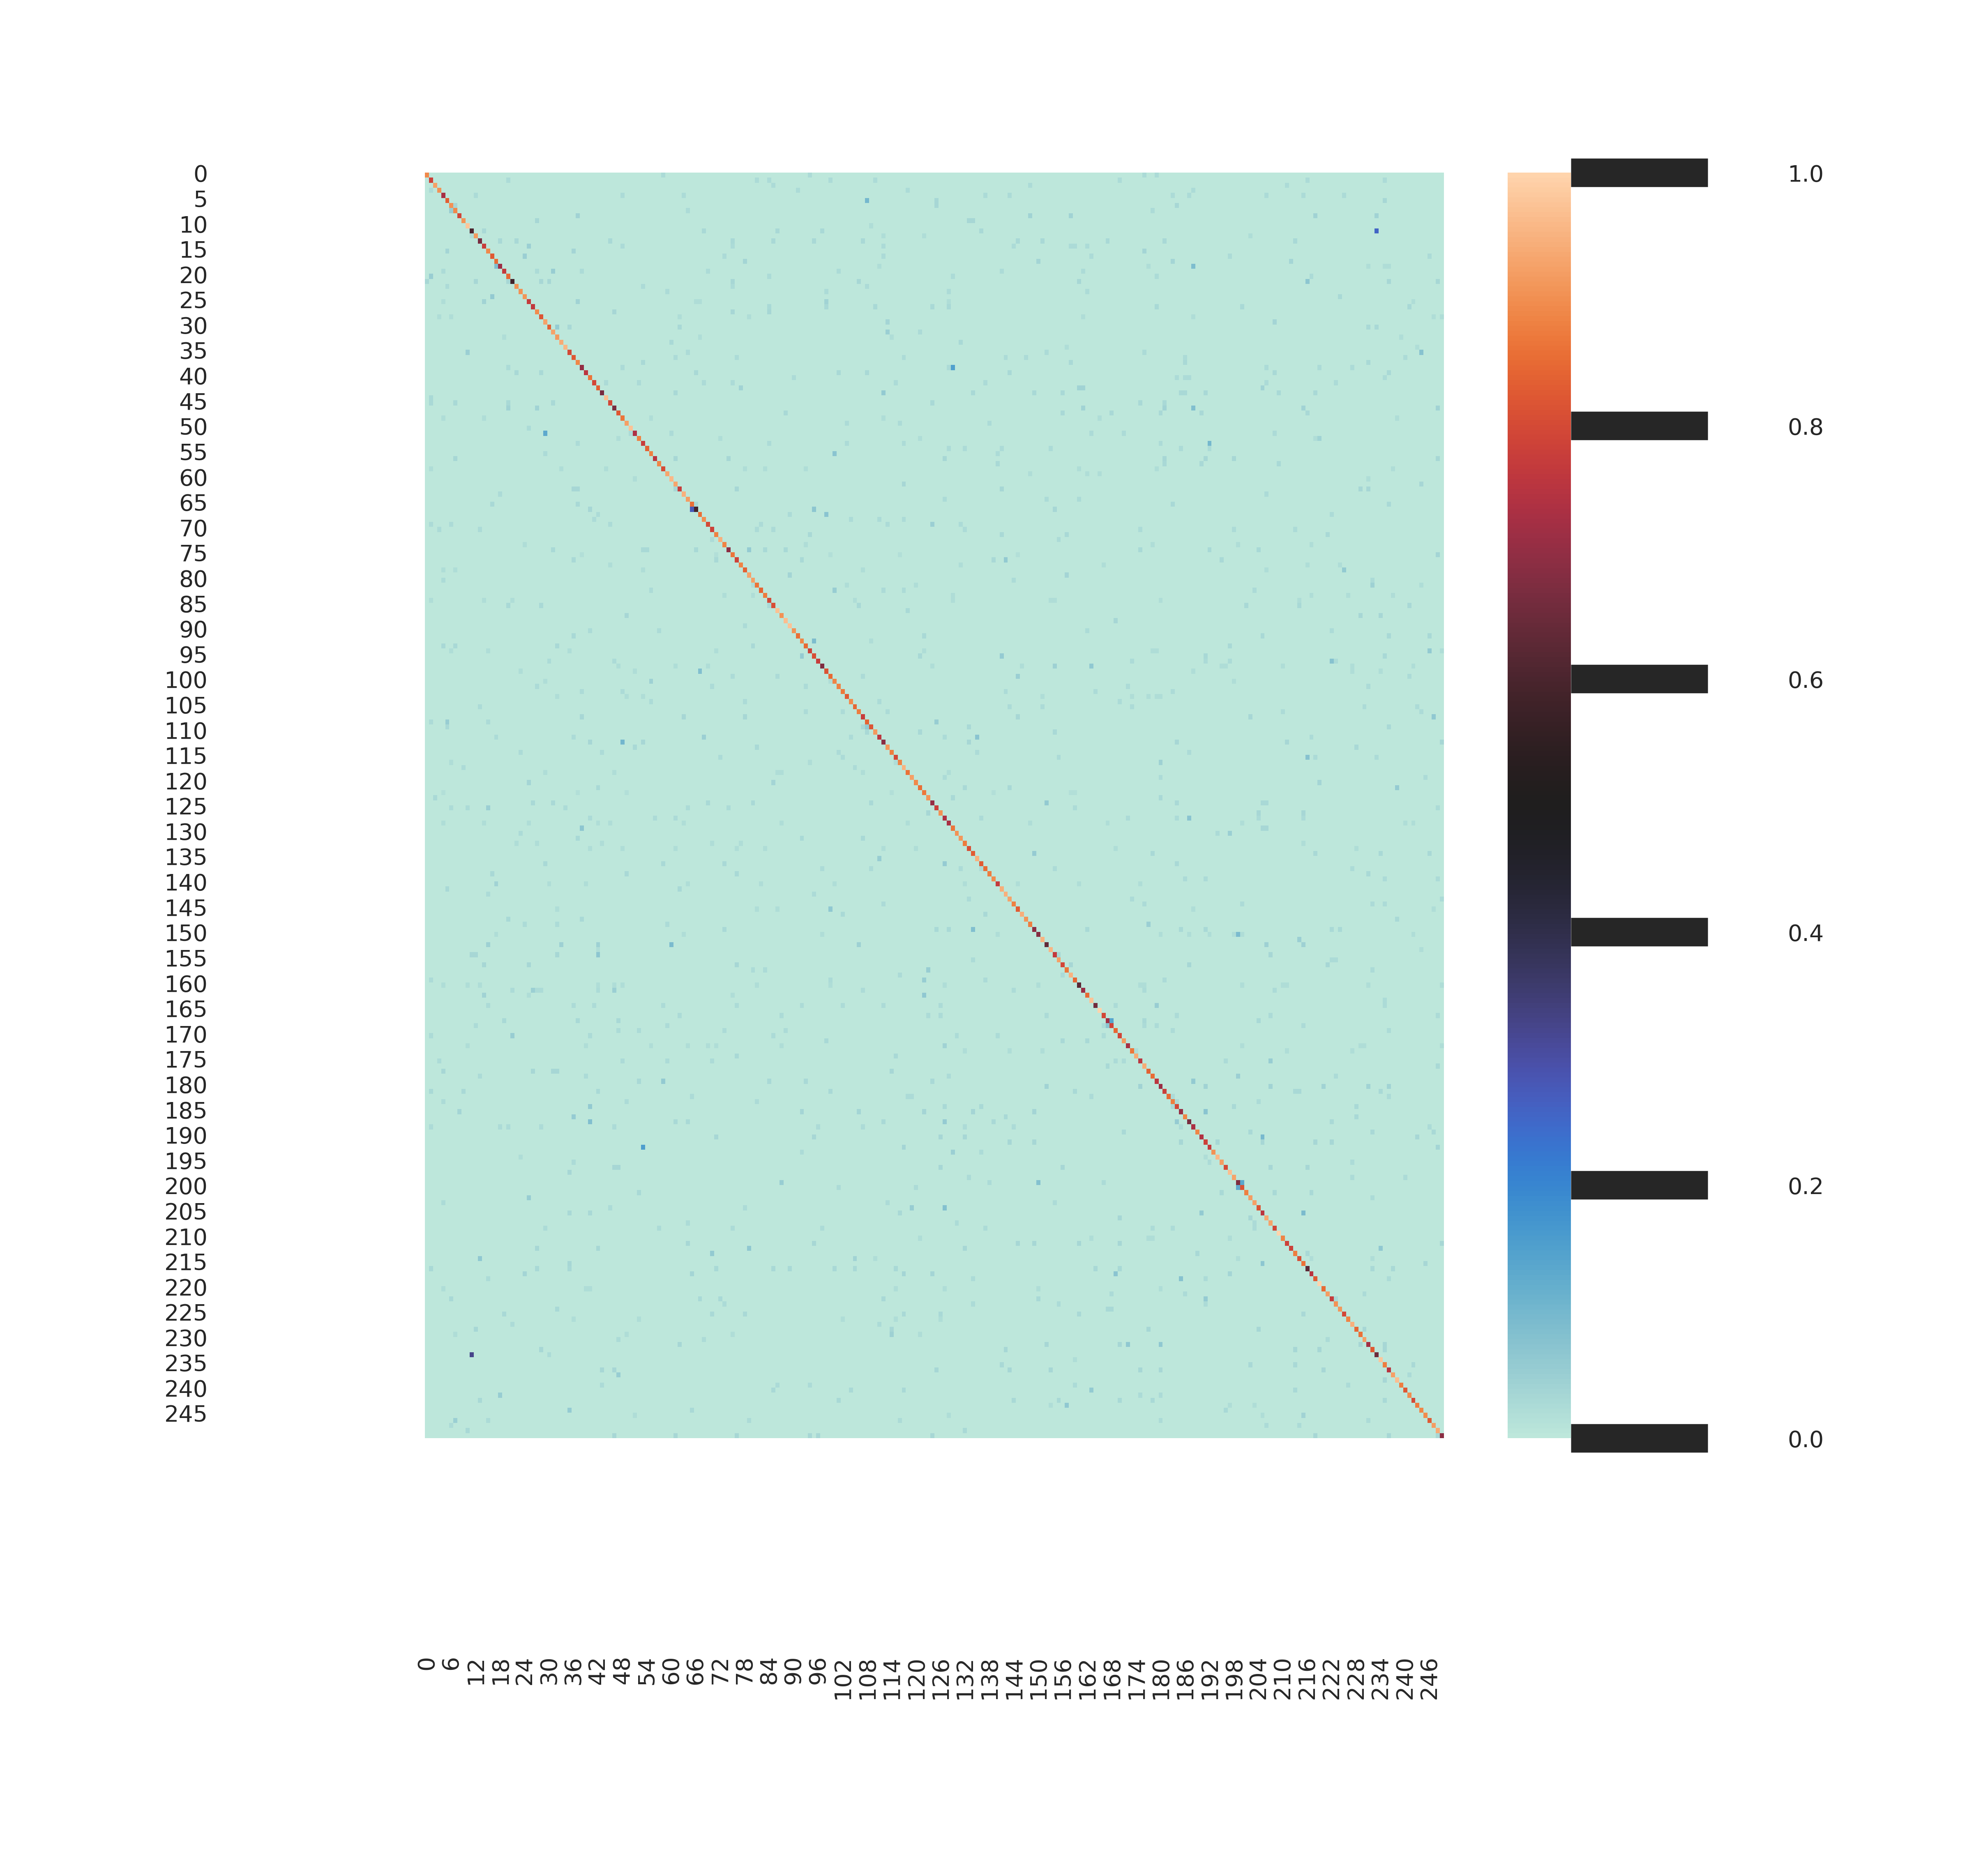

In [99]:
# import seaborn as sns

# # Change figure size and increase dpi for better resolution
# plt.figure(figsize=(1,1), dpi=4000)
# # Scale up the size of all text
# sns.set(font_scale = 0)

# # Plot Confusion Matrix using Seaborn heatmap()
# # Parameters:
# # first param - confusion matrix in array format   
# # annot = True: show the numbers in each heatmap cell
# # fmt = 'd': show numbers as integers. 
# ax = sns.heatmap(cm, annot=False,cmap="icefire" )
# plt.savefig('fireice_4000.png')

In [63]:
# y_val_pred[y_val != y_val_pred]
incorrect_preds = pd.DataFrame([ORD2SIGN[i] for i in y_val_pred[y_val != y_val_pred]],
                               [ORD2SIGN[i] for i in y_val[y_val != y_val_pred]]).reset_index()

incorrect_preds = incorrect_preds.rename(columns={'index':'prediction',0:'label'})
incorrect_preds.head()

,prediction,label
0,clean,pool
1,fast,make
2,arm,lips
3,pen,pencil
4,open,potty


In [73]:
incorrect_preds[incorrect_preds['label']=='hello']

,prediction,label
267,brown,hello
396,hat,hello
878,brown,hello
923,boy,hello
1266,elephant,hello
1293,snow,hello


# Training History

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    config["N_EPOCHS"] = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if config["N_EPOCHS"] <= 20:
        x = np.arange(1, config["N_EPOCHS"] + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((config["N_EPOCHS"] - 10) // 5 + 1)]

    x_ticks = np.arange(1, config["N_EPOCHS"]+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [ ]:
plot_history_metric('loss', f_best=np.argmin)

In [ ]:
plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [ ]:
plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [ ]:
plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [15]:
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y']
    data = pd_read_s3_parquet(pq_path[14:], AWS_S3_BUCKET, s3_client, columns=data_columns)
    n_frames = int(len(data) / 543)
    data = data.values.reshape(n_frames, 543, len(data_columns))
    return data.astype(np.float32)

In [44]:
preprocess_layer = PreprocessLayerV2(config["INPUT_SIZE"])

In [45]:
preprocess_layer(load_relevant_data_subset("w251-asl-data/raw-data/train_landmark_files/28656/1000106739.parquet"))


(<tf.Tensor: shape=(38, 454), dtype=float32, numpy=
 array([[ 0.35477105,  0.77816063,  0.27789864, ..., -0.5786116 ,
          0.76873696, -0.6725151 ],
        [-0.27624363,  0.67679495, -0.35129297, ...,  1.3697093 ,
          0.7903673 ,  1.5212379 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32)>,
 <tf.Tensor: shape=(38,), dtype=float32, numpy=
 array([ 0., 10., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       dtype=float32)>)

In [221]:
# model

In [98]:
# inputs = tf.keras.Input(shape=(config["N_ROWS"], config["N_DIMS"]))
# x, non_empty_frame_idxs = preprocess_layer(inputs)
# # outputs = training_model(x)
# preprocess_model = tf.keras.Model(inputs=inputs, outputs=[x, non_empty_frame_idxs])

In [46]:
# TFLite model for submission
class TFLiteModel(tf.keras.Model):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, config["N_ROWS"], config["N_DIMS"]], dtype=tf.float32, name='inputs')])
    def call(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({'FRAMES': x, 'NON_EMPTY_FRAME_IDXS': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)


In [47]:
version = 2
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
keras_model_converter.experimental_new_converter = True

# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open(f'tflite_models/v{version}_again_model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Zip Model
# !zip submission.zip /kaggle/working/model.tflite

2023-04-17 22:10:44.065362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,543,2]
	 [[{{node inputs}}]]
2023-04-17 22:10:44.065472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'preprocess_layer_v2_1/94535' with dtype int32 and shape [227]
	 [[{{node preprocess_layer_v2_1/94535}}]]
2023-04-17 22:10:44.400227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5

INFO:tensorflow:Assets written to: /tmp/tmpivtdi300/assets


INFO:tensorflow:Assets written to: /tmp/tmpivtdi300/assets
2023-04-17 22:10:57.814315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_inputs' with dtype float and shape [?,543,2]
	 [[{{node serving_default_inputs}}]]
2023-04-17 22:10:59.332285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'slice_begin_values_1' with dtype int32
	 [[{{node slice_begin_values_1}}]]
2023-04-17 22:10:59.332422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value fo

In [ ]:
# Sanity Check
demo_raw_data = load_relevant_data_subset(train['path'].values[5])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

In [55]:
# Verify TFLite model can be loaded and used for prediction
# !pip install tflite-runtime
# import tf.lite.interpreter as tflite

test_input = load_relevant_data_subset("w251-asl-data/raw-data/train_landmark_files/28656/1000106739.parquet")

interpreter = tf.lite.Interpreter("tflite_models/v2_again_model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=test_input)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')

PRED :  wait [232]
TRUE :  blow [25]


In [85]:
# interpreter.get_signature_list()

input_data = load_relevant_data_subset("w251-asl-data/raw-data/train_landmark_files/28656/1000106739.parquet")


In [86]:
output = interpreter.get_output_details()[0]
input_1 = interpreter.get_input_details()[0]

interpreter.set_tensor(input_1['index'], input_data)
interpreter.invoke()
interpreter.get_tensor(output['index']).shape

ValueError: Cannot set tensor: Dimension mismatch. Got 11 but expected 1 for dimension 0 of input 0.

In [87]:
input_1

{'name': 'inputs',
 'index': 0,
 'shape': array([  1, 543,   2], dtype=int32),
 'shape_signature': array([ -1, 543,   2], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [88]:
output

{'name': 'Identity',
 'index': 448,
 'shape': array([250], dtype=int32),
 'shape_signature': array([250], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}